In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv("water_potability.csv")
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [3]:
df.shape

(3276, 10)

# Predictor Description

**pH value: Evaluates the acid-base balance of water. Also the indicator of acidic or alkaline condition of water status. WHO recommends max permissible limit of pH from 6.5 to 8.5 for potability.**

**Hardness: Mainly caused by calcium and magnesium salts, dissolved from the geologic deposits where water travels. The longer water is in contact with this material helps determine how much hardness there is in the water.**

**Solids (Total Dissolved Solids): Minerals (organic and inorganic) dissolved in water that produce an unwanted taste and color in water. High TDS means the water is highly mineralized. Limits of TDS for drinking water are from 500mg/l to 1000 mg/l.**

**Chloramines: Chloramines formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 mg/L are safe to drink.**

**Sulfate: Naturally occurring substances in minerals, soil, and rocks. Also used in the chemical industry. Ranges from 3-30mg/L in most freshwater supplies.**

**Conductivity: Pure water is not a good conudctor. Increase in the concentation of ions enhances the conductivity. EC value should not exceed 400 uS/cm**

**Organic carbon: Comes from decaying natural organic matter and synthetic sources. < 2 mg/L as TOC in treated/drinking water recommended.**

**Trihalomethanes: THMs are a chemical found in water treated with chlorine. THM levels up to 80 ppm is considered safe in drinking water.**

**Turbidity: Dependent on the quantity of solid matter present in the suspended state. WHY recommended value of 5.00 NTU.**

**Potability: 1 means potable and 0 means not potable**

# DF info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


**There are null values in the df. All predictors (9) are continuous, and the response is categorical.**

# Distribution of 0s and 1s for response

In [5]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [6]:
d = pd.DataFrame(df["Potability"].value_counts())
fig = px.pie(d, values = "Potability", names = ["Not Potable", "Potable"], hole = 0, opacity = 0.7,
                                               labels = {"label":"Potability", "Potability":"Number of Samples"})
fig.update_layout(title = dict(text = "Pie Chart of Potability"))
fig.update_traces(textposition = "outside", textinfo = "percent + label")
fig.show()

<BarContainer object of 2 artists>

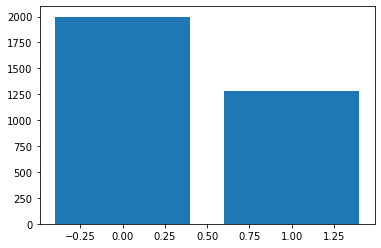

In [7]:
# Count the occurrences of each category
category_counts = df['Potability'].value_counts()

# Create bar plot
plt.bar(category_counts.index, category_counts.values)

# Summary statistics

In [8]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

**All predictors will need to be scaled, because they are on very different scales.**

# Null values

In [9]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

**Because this dataset has around 3,000 observations with 1,000 observations having missing values, we did not want to drop 1/3 of this information.** 

**Using KNN to impute missing values**

In [10]:
X = df.drop(columns= 'Potability')
y = df['Potability']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [12]:
MSE_whole_data = []
#Iterate over the potential optimal values of the hyperparameter 'k' of the KNN algorithm
for k in range(1, 51):
    #Impute the missing values of X_scaled (5380 rows, 765 columns) with the 'k' under consideration
    #Let us call the imputed dataset as 'X_imputed_k'. This dataset has no missing values.
    imputer = KNNImputer(n_neighbors=k)
    X_imputed_k = imputer.fit_transform(X_scaled)
    X_imputed_k = pd.DataFrame(X_imputed_k, columns=X_scaled.columns)
    MSE_multiplied = []
    MSE = []
    #Iterate over each predictor in the data
    for predictor in X_scaled.columns:
        #If there are no missing values in 'predictor', skip the lines below, and continue with the next predictor
        if X_scaled[predictor].isna().sum() == 0:
            continue
        #Remove the observations from 'X_imputed_k', where the 'predictor' has actual missing values.
        #We don't know the true values of those observations for the 'predictor' column, and hence cannot 
        #compute the cross-validation error on them. Let the dataframe with the removed observations be
        #X_imputed_non_missing_k 
        missing_mask = X_scaled[predictor].isna()
        X_imputed_non_missing_k = X_imputed_k.loc[~missing_mask, :]
        #Similarly, remove the observations that have missing values in 'predictor' and call the 
        #resulting Series as 'predictor_nonmissing'
        predictor_nonmissing = X_scaled.loc[~missing_mask, predictor]
        #Consider 'predictor_nonmissing' as the response, and 'X_imputed_non_missing_k' as predictors
        knn = KNeighborsRegressor(n_neighbors=k)
        #Use cross_val_score to compute the 5-fold cross-validated MSE when 'predictor_nonmissing' is 
        #predicted using 'X_imputed_non_missing_k' as the set of predictors, with the KNN model having
        #K = k
        cv_scores= -cross_val_score(knn, X_imputed_non_missing_k, predictor_nonmissing, cv=5, scoring='neg_mean_squared_error')
        #Compute the weighted average of MSEs, and then MSE_whole_data_k as mentioned in steps 6-7 of the announcement
        MSE.append(np.mean(cv_scores))
        MSE_multiplied.append(np.mean(cv_scores) * missing_mask.sum())
    total_se_k = sum(MSE_multiplied)
    MSE_whole_data_k = total_se_k / X_scaled.isnull().sum().sum()
    MSE_whole_data.append(MSE_whole_data_k)

In [13]:
# Find optimal K
optimal_k = np.argmin(MSE_whole_data) + 1
MSE_optimal_k = MSE_whole_data[optimal_k - 1]
print("Optimal K:", optimal_k)
print('MSE for the optimal K:', MSE_optimal_k)

Optimal K: 5
MSE for the optimal K: 0.16072247870117018


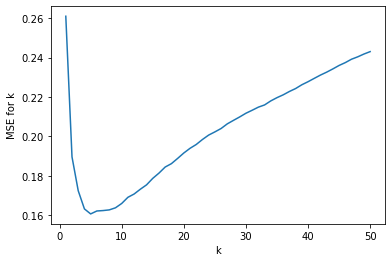

In [14]:
#plot MSEwhole_data_k vs k, and report the (2) optimal K, (3) MSEwhole_data_K for the optimal K, and (4) the option (a) or (b) chosen in step 4.
#Note that this template is for following option (a) in step 4 in the announcement.
# Plot MSEwhole_data_k vs k
plt.plot(range(1, 51), MSE_whole_data)
plt.xlabel('k')
plt.ylabel('MSE for k')
plt.show()

In [15]:
# Select the columns with missing values
columns_with_missing = ['ph', 'Sulfate', "Trihalomethanes"]

# Create a copy of the DataFrame
impute_X = X_scaled.copy()

# Perform KNN imputation with the optimal K value
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imputer.fit_transform(impute_X[columns_with_missing])

# Update the original DataFrame with the imputed values
X_scaled[columns_with_missing] = imputed_data

In [16]:
X_scaled.head()

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0 -0.209627  0.259195 -0.139471     0.112415  0.838973      1.708954   
1 -2.110818 -2.036414 -0.385987    -0.307694 -0.512637      2.062575   
2  0.638838  0.847665 -0.240047     1.360594 -0.333799     -0.094032   
3  0.775374  0.547651  0.000493     0.592008  0.558106     -0.778830   
4  1.261849 -0.464429 -0.460249    -0.363698 -0.570898     -0.343939   

   Organic_carbon  Trihalomethanes  Turbidity  
0       -1.180651         1.273445  -1.286298  
1        0.270597        -0.622493   0.684218  
2        0.781117         0.001472  -1.167365  
3        1.255134         2.098969   0.848412  
4       -0.824357        -2.126974   0.138786

# Variable Analysis

In [17]:
d = pd.DataFrame(df["Potability"].value_counts())
fig = px.pie(d, values = "Potability", names = ["Not Potable", "Potable"], hole = 0, opacity = 0.7,
                                               labels = {"label":"Potability", "Potability":"Number of Samples"})
fig.update_layout(title = dict(text = "Pie Chart of Potability"))
fig.update_traces(textposition = "outside", textinfo = "percent + label")
fig.show()

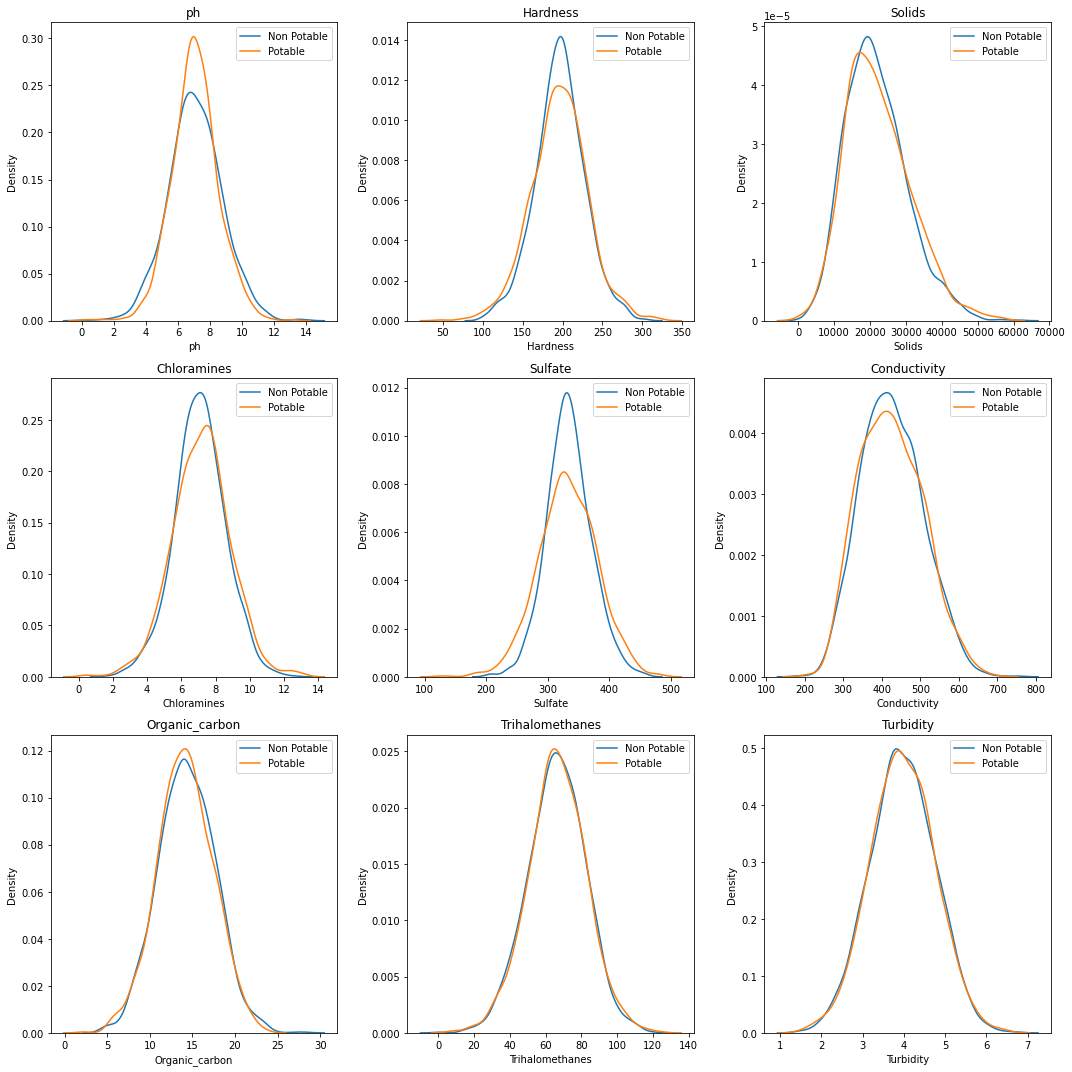

In [18]:
non_potable = df.query("Potability == 0")
potable = df.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax, col in  enumerate(df.columns[:9]):
    plt.subplot(3,3, ax+1)
    plt.title(col)
    sns.kdeplot(x = non_potable[col], label = "Non Potable")
    sns.kdeplot(x = potable[col], label = "Potable")
    plt.legend()
plt.tight_layout()

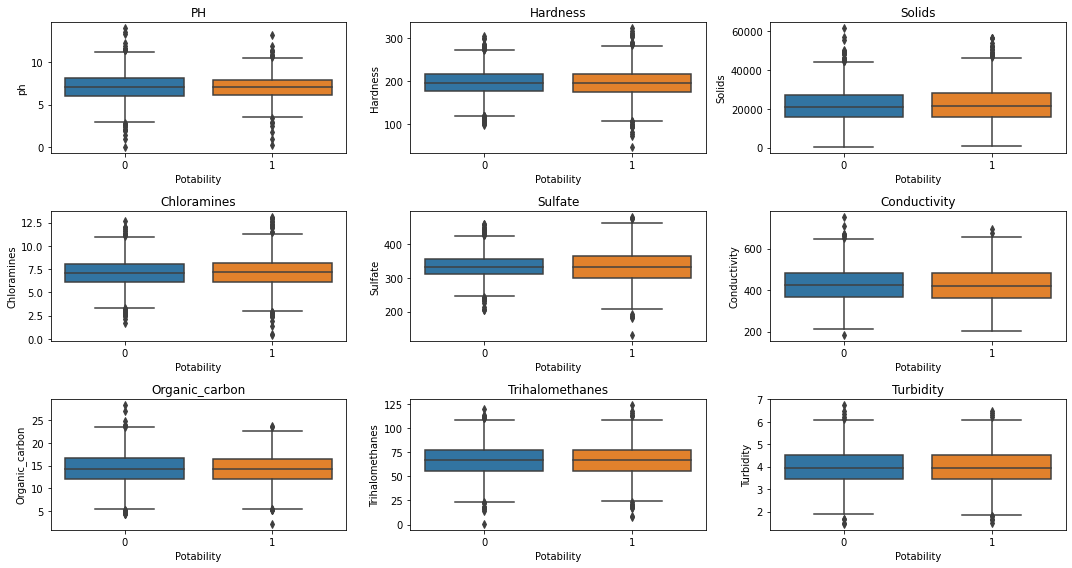

In [19]:
fig, ax = plt.subplots(3, 3, figsize = (15,8))

plt.setp(ax[0,0], title = 'PH')
sns.boxplot(x='Potability', y='ph', data = df, ax = ax[0,0])

plt.setp(ax[0,1], title = 'Hardness')
sns.boxplot(x='Potability', y='Hardness', data = df, ax = ax[0,1])

plt.setp(ax[0,2], title = 'Solids')
sns.boxplot(x='Potability', y='Solids', data = df, ax = ax[0,2])

plt.setp(ax[1,0], title = 'Chloramines')
sns.boxplot(x='Potability', y='Chloramines', data = df, ax = ax[1,0])

plt.setp(ax[1,1], title = 'Sulfate')
sns.boxplot(x='Potability', y='Sulfate', data = df, ax = ax[1,1])

plt.setp(ax[1,2], title = 'Conductivity')
sns.boxplot(x='Potability', y='Conductivity', data = df, ax = ax[1,2])

plt.setp(ax[2,0], title = 'Organic_carbon')
sns.boxplot(x='Potability', y='Organic_carbon', data = df, ax = ax[2,0])

plt.setp(ax[2,1], title = 'Trihalomethanes')
sns.boxplot(x='Potability', y='Trihalomethanes', data = df, ax = ax[2,1])

plt.setp(ax[2,2], title = 'Turbidity')
sns.boxplot(x='Potability', y='Turbidity', data = df, ax = ax[2,2])

plt.tight_layout()

**All predictors contain variance and appear to have reasonable values.**

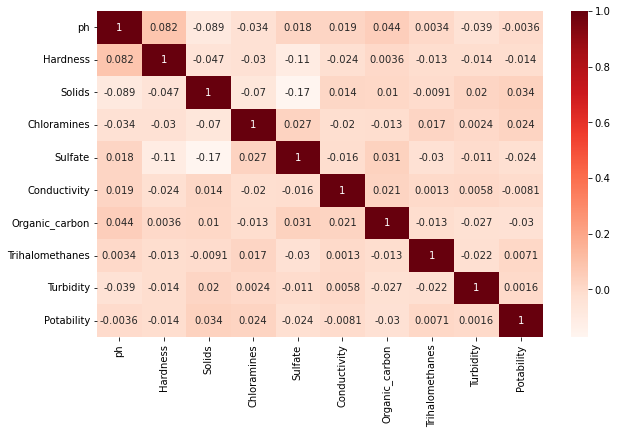

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),cmap=plt.cm.Reds,annot=True)
plt.show()

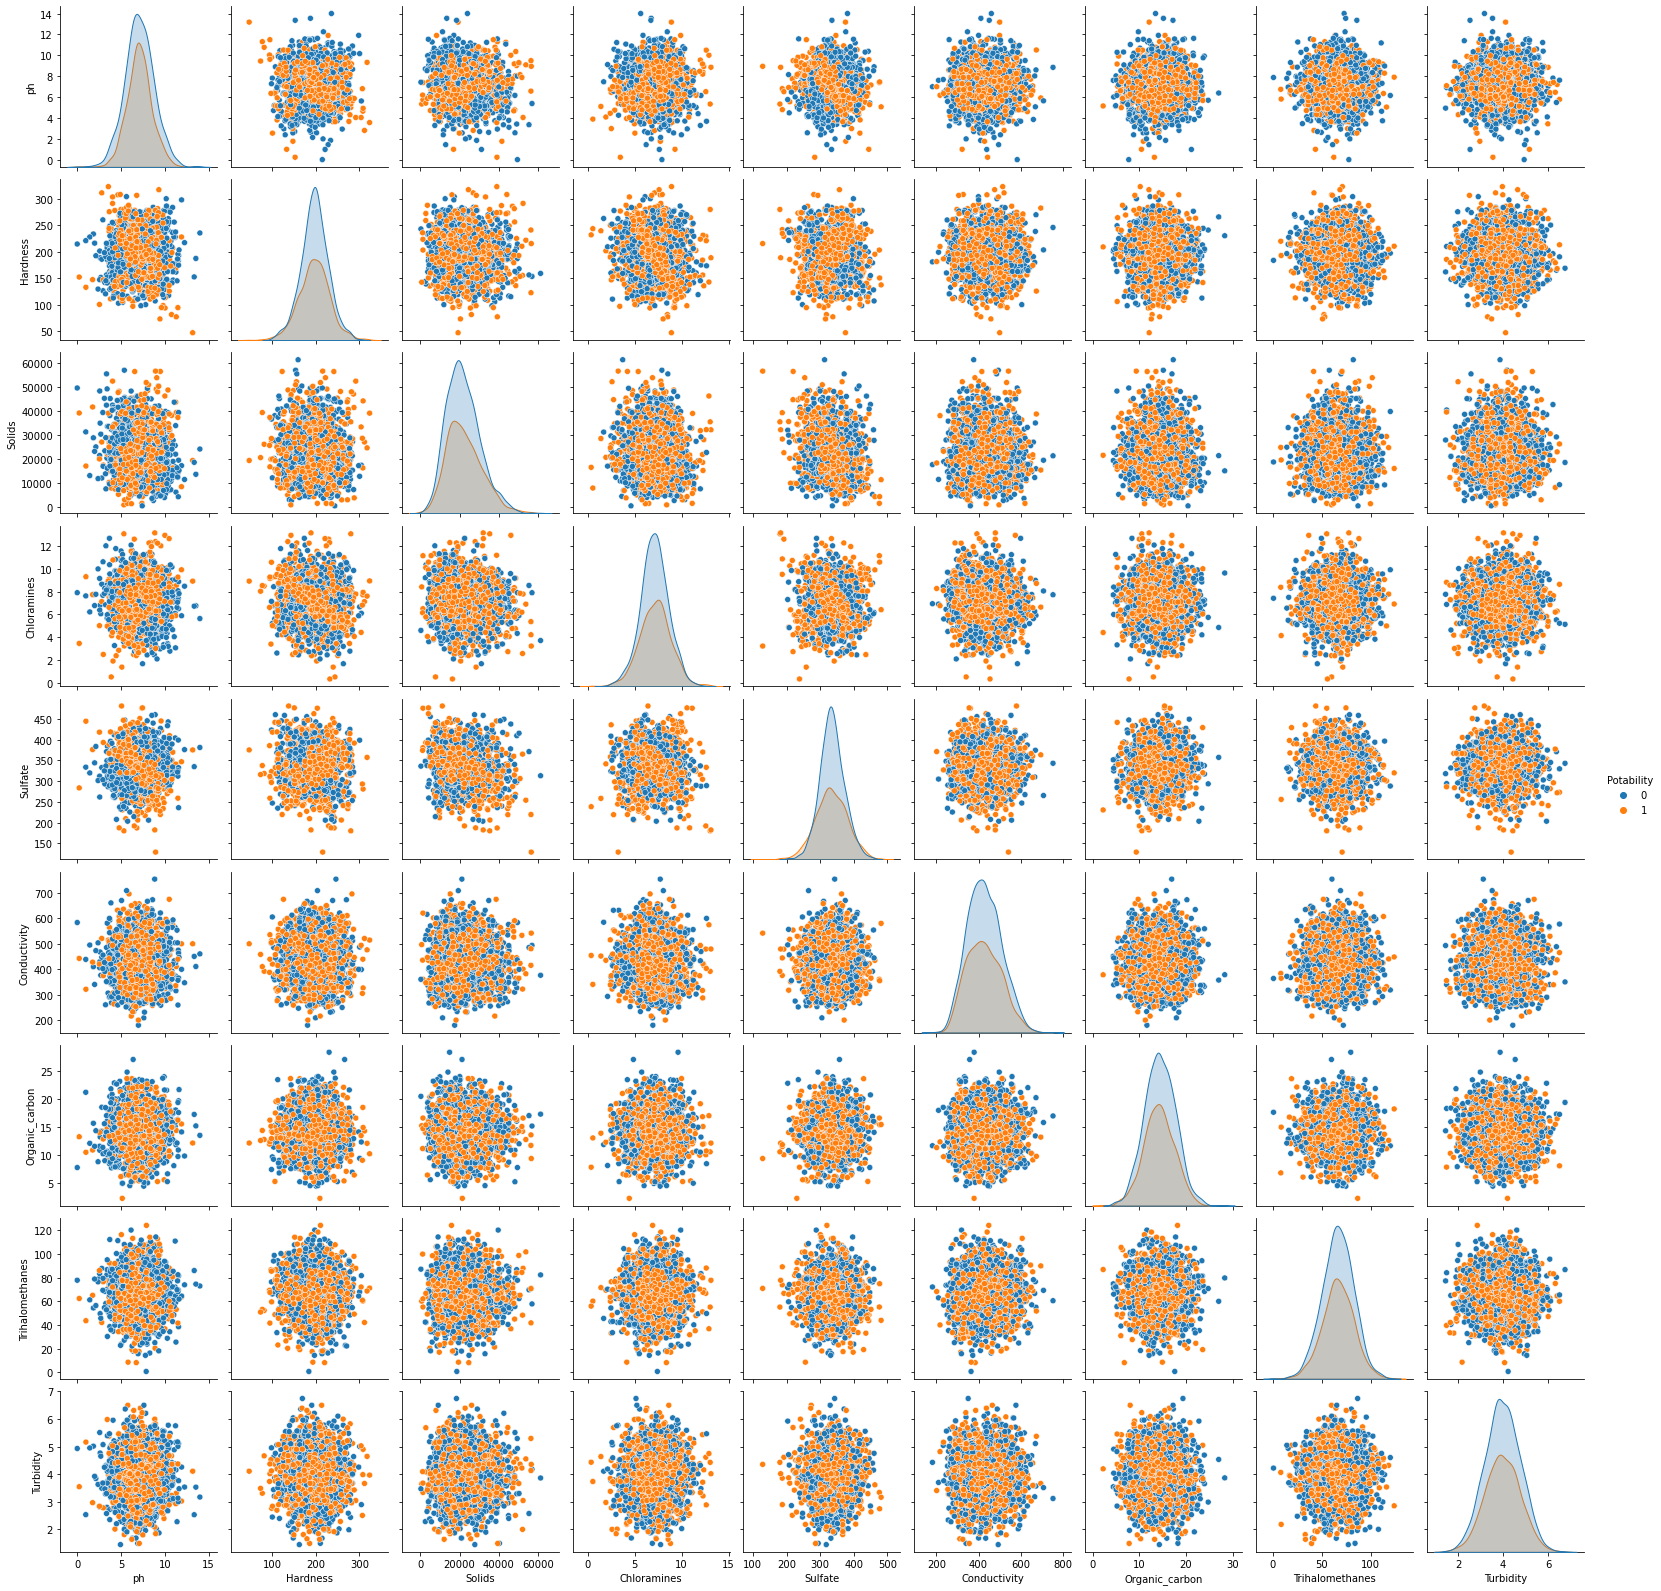

In [21]:
sns.pairplot(df, hue='Potability')

plt.show()

# Finding Unique Values

In [22]:
def uni(df):

    for i in range(len(df.columns)):
        print('\n All Unique Value in ' + str(df.columns[i]))
        print(np.sort(df[df.columns[i]].unique()))
        print('Total no of unique values ' +
              str(len(df[df.columns[i]].unique())))

In [23]:
uni(df)


 All Unique Value in ph
[ 0.          0.22749905  0.97557799 ... 13.54124024 14.
         nan]
Total no of unique values 2786

 All Unique Value in Hardness
[ 47.432       73.49223369  77.4595861  ... 311.38395647 317.33812406
 323.124     ]
Total no of unique values 3276

 All Unique Value in Solids
[  320.94261127   728.75082958  1198.94369901 ... 56488.67241274
 56867.85923615 61227.19600771]
Total no of unique values 3276

 All Unique Value in Chloramines
[ 0.352       0.53035129  1.3908709  ... 12.91218664 13.04380611
 13.127     ]
Total no of unique values 3276

 All Unique Value in Sulfate
[129.         180.20674636 182.39737025 ... 476.53971733 481.03064231
          nan]
Total no of unique values 2496

 All Unique Value in Conductivity
[181.48375399 201.61973676 210.31918197 ... 695.36952799 708.22636447
 753.34261956]
Total no of unique values 3276

 All Unique Value in Organic_carbon
[ 2.2         4.37189861  4.46677197 ... 24.75539237 27.00670661
 28.3       ]
Total no of 

# Random Forest Model and Parameter Tuning

In [24]:
X = df.drop(columns = "Potability")
y = df.Potability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45)
X_train.shape

(1965, 9)

In [25]:
model = RandomForestClassifier(random_state=45)
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
#Optimizing with OOB score takes half the time as compared to cross validation. 
#The number of models developed with OOB score tuning is one-fifth of the number of models developed with
#5-fold cross validation
import itertools as it


n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_samples

In [71]:
n_features

9

In [72]:
print(model.max_depth)

None


In [ ]:
# 'max_depth': range(4, 29, 2),
    #'max_leaf_nodes': range(2,455, 10),
   # 'max_features': range(1, 10)

In [73]:
params = {'n_estimators': [50],
          'max_depth': range(8, 30, 4), #what were these changed to, just deleted
          'max_leaf_nodes': range(20, 36, 4), #this was changed, forget
        'max_features': range(2, 10),
         'sub_samples':[0.5]}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_precision = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],
                                  max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X_train,y_train)
    oob_pred = (model.oob_decision_function_[:,1]>=0.5).astype(int)     
    oob_precision[i] = precision_score(y_train, oob_pred)
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_precision)])
print("Best score (R-squared) = ", np.max(oob_precision))

Best params =  (100, 8, 48, 2)
Best score (R-squared) =  0.7094017094017094


In [74]:
model = RandomForestClassifier(random_state=1, max_features=4, n_estimators = 100, 
                               oob_score=True, max_depth =12, max_leaf_nodes = 36).fit(X_train, y_train)

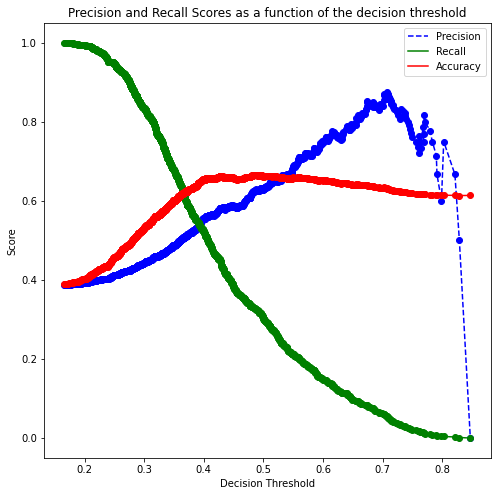

In [75]:
y_pred_prob = model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [76]:
# Thresholds with precision and recall
con = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1), acc.reshape(-1,1)], axis = 1)

In [77]:
con[(con[:,2]>0.6),:]

array([[0.1660508 , 0.38744257, 1.        , 0.38880407],
       [0.16740785, 0.38712972, 0.99868248, 0.38931298],
       [0.16953651, 0.38732754, 0.99868248, 0.38982188],
       ...,
       [0.36910604, 0.51004464, 0.60210804, 0.62340967],
       [0.3691513 , 0.51061453, 0.60210804, 0.62290076],
       [0.3695165 , 0.51006711, 0.60079051, 0.62239186]])

Accuracy:  76.23409669211196
ROC-AUC:  0.8891576373730818
Precision:  0.8821989528795812
Recall:  0.4440052700922266


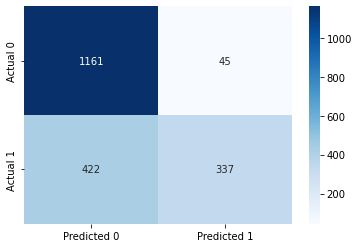

In [78]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.6

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  64.22578184591914
ROC-AUC:  0.6512134835834258
Precision:  0.6059322033898306
Recall:  0.27552986512524086


<AxesSubplot:>

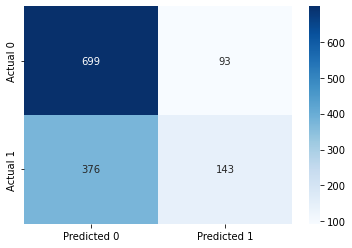

In [79]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# XGBoost Model and Parameter Tuning

In [82]:
df1 = pd.read_csv("water_potability.csv")
X = df1.drop(columns = "Potability")
y = df1.Potability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 45)

In [81]:
import xgboost as xgb
param_grid = {'n_estimators':[100,500],
                'max_depth': [4, 6,8],
              'learning_rate': [.001, .01, 0.1,1.0],
               'gamma': [0.1, 1, 10],
               'reg_lambda':[1, 10, 100],
                'subsample':[0.25, .5, .75, 1.0], 
              'scale_pos_weight': [1.589], 
              'colsample_by_tree': [.25, .5, .75, 1.0]
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                              scoring=['precision', 'accuracy'], refit = 'precision',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/Users/karrinedenisova/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/Users/karrinedenisova/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



KeyboardInterrupt: 

In [38]:
cv_results=pd.DataFrame(optimal_params.cv_results_)


In [37]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [39]:
model4 = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=10,learning_rate = 1.0,max_depth=4,
                              n_estimators = 500,reg_lambda = 100,scale_pos_weight=1.589, subsample = 0.25, n_jobs = -1)
model4.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

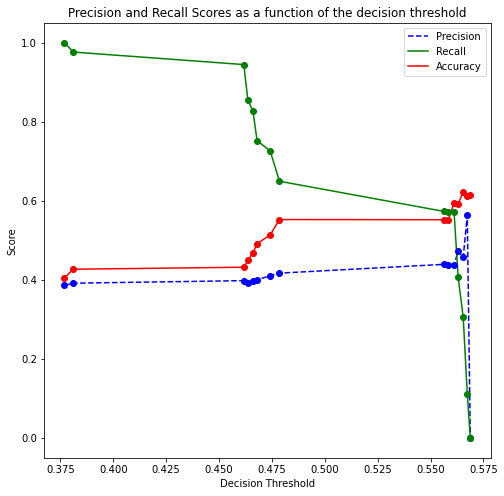

In [40]:
y_pred_prob = model4.predict_proba(X_train)[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

1.5889328063241106

In [43]:
param_grid = {'n_estimators':[400, 500, 600, 1000],
                'max_depth': [4,5],
              'learning_rate': [.001, .01, 0.1,1.0],
               'gamma': [5,10, 20, 30],
               'reg_lambda':[50,100, 150],
                'subsample':[0.1 ,.2, .3, .4], 
              'scale_pos_weight': [1.589]
             }

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,
                                                         use_label_encoder=False),
                             param_grid = param_grid,
                              scoring=['recall', 'accuracy'], refit = 'recall',
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_,optimal_params.best_score_)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


/Users/karrinedenisova/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/Users/karrinedenisova/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



{'gamma': 5, 'learning_rate': 1.0, 'max_depth': 4, 'n_estimators': 1000, 'reg_lambda': 100, 'scale_pos_weight': 1.589, 'subsample': 0.1} 0.8026315789473685


In [ ]:
cv_results=pd.DataFrame(optimal_params.cv_results_)

In [83]:
model4 = xgb.XGBClassifier(objective = 'binary:logistic',random_state=1,gamma=5,learning_rate = 1.0,max_depth=4,
                              n_estimators = 1000,reg_lambda = 100,scale_pos_weight=1.589, subsample = 0.1, n_jobs = -1)
model4.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

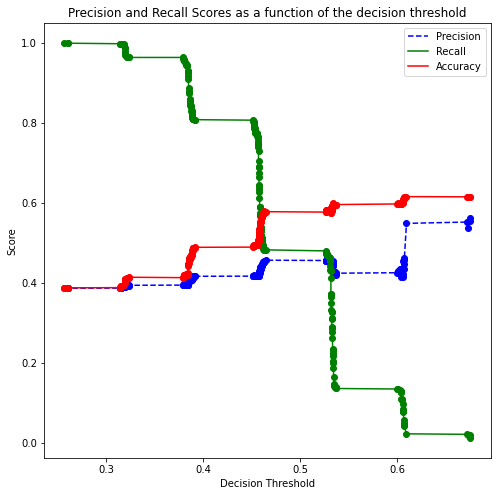

In [86]:
y_pred_prob = model4.predict_proba(X_train)[:,1]
p, r, thresholds = precision_recall_curve(y_train, y_pred_prob)
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = y_pred_prob > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [87]:
all_thresholds = np.concatenate([thresholds.reshape(-1,1), acc.reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
all_thresholds

array([[0.25670403, 0.38575064, 1.        ],
       [0.25998729, 0.38676845, 0.99868248],
       [0.26037231, 0.38727735, 0.99868248],
       [0.31407085, 0.38778626, 0.99736495],
       [0.31450194, 0.38829517, 0.99736495],
       [0.31484213, 0.38880407, 0.99736495],
       [0.31486964, 0.39083969, 0.99736495],
       [0.31530127, 0.39185751, 0.99736495],
       [0.31543592, 0.39236641, 0.99604743],
       [0.31820798, 0.39338422, 0.99604743],
       [0.31864217, 0.39541985, 0.99077734],
       [0.31898466, 0.39949109, 0.98550725],
       [0.31901237, 0.40356234, 0.98550725],
       [0.31941935, 0.40508906, 0.97760211],
       [0.31944704, 0.40814249, 0.97760211],
       [0.31958276, 0.40916031, 0.96969697],
       [0.32001793, 0.40916031, 0.9657444 ],
       [0.32157803, 0.41068702, 0.96310935],
       [0.32160118, 0.41119593, 0.96310935],
       [0.32297787, 0.41272265, 0.96310935],
       [0.32341543, 0.41374046, 0.96310935],
       [0.37905458, 0.41272265, 0.96310935],
       [0.